In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import pandas as pd 
import numpy as np 
import seaborn as sns
import random 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing

tfk = tf.keras
tfkl = tf.keras.layers

Num GPUs Available:  1


In [2]:
BATCH_SIZE = 32
SHAPE = (4096, 23)
BLOCK_SHAPE = (64, 23)
EPOCHS = 30
VARIABLES = 23
NFOLD = 5 
STEPS_PER_EPOCH = 200
ID = 28

In [3]:
if ID == 28:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C28.csv'
elif ID == 37:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C37.csv'
else:
    print('Invalid ID')
df_test = pd.read_csv(file, nrows=100)
float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float16 for c in float_cols}

df = pd.read_csv(file, dtype=float32_cols, engine='c')
df['id'] = df.id.astype('int32')
df = df.dropna()

In [4]:
sources = df[['id', 'plane_id', 'split', 'date_diff', 'before_after']].drop_duplicates()
sources.loc[: , ['split', 'before_after', 'id']].groupby(['split', 'before_after']).count()

id
split before_after     
0     0             589
      1             484
1     0             555
      1             449
2     0             641
      1             552
3     0             343
      1             282
4     0             456
      1             382

In [5]:
input_columns = ['volt1',
 'volt2',
 'amp1',
 'amp2',
 'FQtyL',
 'FQtyR',
 'E1 FFlow',
 'E1 OilT',
 'E1 OilP',
 'E1 RPM',
 'E1 CHT1',
 'E1 CHT2',
 'E1 CHT3',
 'E1 CHT4',
 'E1 EGT1',
 'E1 EGT2',
 'E1 EGT3',
 'E1 EGT4',
 'OAT',
 'IAS',
 'VSpd',
 'NormAc',
 'AltMSL']

In [6]:
preprocess = preprocessing.MinMaxScaler()
preprocess.fit(df.loc[:, input_columns].sample(100000, random_state = 0 ))
org_value = df.loc[:, input_columns].values
res = preprocess.transform(org_value)
for i, col in enumerate(input_columns):
    df.loc[:, col] = res[:, i]

D:\Python-Anaconda\envs\tf\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [7]:
def get_dataset(df): 

    ids = df.id.unique()

    sensor_datas = []
    afters = [] 

    for id in ids: 
        sensor_data = df[df.id == id].iloc[-SHAPE[0]:, :23].values

        sensor_data = np.pad(sensor_data, [[0, SHAPE[0]- len(sensor_data)], [0,0]])

        sensor_data = tf.convert_to_tensor(sensor_data, dtype = tf.float32) 

        after = df[df.id == id]['before_after'].iloc[0]

        sensor_datas.append(sensor_data)
        afters.append(after)


    sensor_datas = tf.stack(sensor_datas)
    afters = np.stack(afters)

    ds = tf.data.Dataset.from_tensor_slices( (sensor_datas, afters))
    
    return ds

In [8]:
def slice_random(x, y):
    start = tf.random.uniform(shape=[], minval=0, maxval=4096-BLOCK_SHAPE[0], dtype=tf.int64)
    x = x[start: start + BLOCK_SHAPE[0]]
    x = tf.reshape(x, (BLOCK_SHAPE))
    return x, y 

In [9]:
def fix_type(x, y):

    return tf.cast(x, tf.float32), tf.cast(y, tf.float32)

In [10]:
def prepare_for_training(ds, shuffle = False, repeat = False, predict= True):
    
    ds = ds.map(fix_type)
    ds = ds.map(slice_random)

    ds = ds.shuffle(512) if shuffle else ds 
    ds = ds.repeat() if repeat else ds 
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)

    if not predict: 
        ds = ds.map(lambda x, y : (x, x) ) 
    else: 
        ds = ds.map(lambda x, y : (x, tf.reshape(y, (-1, 1))) )
         
    return ds

In [11]:
def get_train_and_val_for_fold(folded_datasets, fold):
    predict = True

    train = []
    for i in range(NFOLD-1): 
        if i == fold:
            val_ds = folded_datasets[i][0].concatenate(folded_datasets[i][1])
        else: 
            train.append(folded_datasets[i][0])
    
    test_ds = folded_datasets[4][0].concatenate(folded_datasets[4][1])
    
    train_ds = None
    for ds in train: 
        train_ds = ds if train_ds is None else train_ds.concatenate(ds)

    test_ds = prepare_for_training(test_ds, shuffle=False)
    train_ds = prepare_for_training(train_ds, shuffle=True, repeat = True)
    val_ds = prepare_for_training(val_ds, shuffle=False)
    
    return train_ds, val_ds, test_ds

In [12]:
folded_datasets = []

for i in range(NFOLD):
    after = get_dataset(df[(df.split == i) & (df.before_after == 1)])
    before = get_dataset(df[(df.split == i) & (df.before_after == 0)])
    folded_datasets.append((after, before))

In [13]:
class Autoencoder(tfk.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tfk.Sequential([
            tfkl.Input(shape = BLOCK_SHAPE),
            tfkl.Conv1D(256, kernel_size= 3, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1D(128, kernel_size= 3, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1D(64, kernel_size= 3, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1D(32, kernel_size= 3, strides= 2, activation='relu', padding='same'),
        ])
        
        self.decoder = tf.keras.Sequential([
            tfkl.Conv1DTranspose(32, kernel_size= 3, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(64, kernel_size= 3, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(128, kernel_size= 3, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(256, kernel_size= 3, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1D(1, kernel_size = 3, activation='sigmoid', padding='same')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [14]:
class Conv1D(tfk.Model):
    def __init__(self):
        super(Conv1D, self).__init__()
        self.conv1D_model = tfk.Sequential([
            tfkl.Input(shape = BLOCK_SHAPE),
            tfkl.Conv1D(64, kernel_size= 7, strides=2, activation='relu', padding='same'),
            tfkl.Conv1D(64, kernel_size= 7, strides=2, activation='relu', padding='same'),
            tfkl.Conv1D(64, kernel_size= 7, strides=2, activation='relu', padding='same'),
            tfkl.Conv1D(64, kernel_size= 7, strides=2, activation='relu', padding='same'),
            tfkl.GlobalAveragePooling1D(),
            tfkl.Dense(1, activation='sigmoid'),
        ])
            
    def call(self, x):
        conv1D = self.conv1D_model(x)
        return conv1D

In [15]:
cnn1D_encoder_result = {}
for i in range(NFOLD-1):
    autoencoder = Autoencoder()
    autoencoder.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                        metrics = ['accuracy', 
                                   tfk.metrics.RootMeanSquaredError(),
                                  ],
                        loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                       )
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i)   
    
    result = autoencoder.fit(train_dataset, epochs= EPOCHS,steps_per_epoch = STEPS_PER_EPOCH,validation_data= val_dataset,)
    
    cnn1D_encoder_result[i] = result.history

pd.DataFrame(cnn1D_encoder_result)

Epoch 1/30
200/200 [==============================] - 23s 11ms/step - loss: 0.2484 - accuracy: 0.9734 - root_mean_squared_error: 0.4984 - val_loss: 0.2502 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5002
Epoch 2/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2461 - accuracy: 1.0000 - root_mean_squared_error: 0.4960 - val_loss: 0.2505 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5005
Epoch 3/30
200/200 [==============================] - 2s 9ms/step - loss: 0.2423 - accuracy: 1.0000 - root_mean_squared_error: 0.4923 - val_loss: 0.2510 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5010
Epoch 4/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2366 - accuracy: 1.0000 - root_mean_squared_error: 0.4864 - val_loss: 0.2520 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5020
Epoch 5/30
200/200 [==============================] - 2s 9ms/step - loss: 0.2280 - accuracy: 1.0000 - root_mean_squared_error: 0.4775 - val_

Epoch 9/30
200/200 [==============================] - 2s 9ms/step - loss: 0.1526 - accuracy: 1.0000 - root_mean_squared_error: 0.3906 - val_loss: 0.2826 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5316
Epoch 10/30
200/200 [==============================] - 2s 9ms/step - loss: 0.1245 - accuracy: 1.0000 - root_mean_squared_error: 0.3529 - val_loss: 0.3007 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5484
Epoch 11/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0980 - accuracy: 1.0000 - root_mean_squared_error: 0.3131 - val_loss: 0.3225 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5679
Epoch 12/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0745 - accuracy: 1.0000 - root_mean_squared_error: 0.2730 - val_loss: 0.3489 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5906
Epoch 13/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0567 - accuracy: 1.0000 - root_mean_squared_error: 0.2382 - va

Epoch 17/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0239 - accuracy: 1.0000 - root_mean_squared_error: 0.1547 - val_loss: 0.4320 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6573
Epoch 18/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0216 - accuracy: 1.0000 - root_mean_squared_error: 0.1470 - val_loss: 0.4453 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6673
Epoch 19/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0184 - accuracy: 1.0000 - root_mean_squared_error: 0.1355 - val_loss: 0.4555 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6749
Epoch 20/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0167 - accuracy: 1.0000 - root_mean_squared_error: 0.1294 - val_loss: 0.4647 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6817
Epoch 21/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0153 - accuracy: 1.0000 - root_mean_squared_error: 0.1236 

Epoch 25/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0102 - accuracy: 1.0000 - root_mean_squared_error: 0.1012 - val_loss: 0.5084 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7130
Epoch 26/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0104 - accuracy: 1.0000 - root_mean_squared_error: 0.1020 - val_loss: 0.5046 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7103
Epoch 27/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0097 - accuracy: 1.0000 - root_mean_squared_error: 0.0984 - val_loss: 0.5031 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7093
Epoch 28/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0096 - accuracy: 1.0000 - root_mean_squared_error: 0.0982 - val_loss: 0.5068 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7119
Epoch 29/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0093 - accuracy: 1.0000 - root_mean_squared_error: 0.0967 - val

,0,1,2,3
loss,"[0.24838276207447052, 0.24606174230575562, 0.2...","[0.24966734647750854, 0.2482316792011261, 0.24...","[0.2487737536430359, 0.24640055000782013, 0.24...","[0.2495301216840744, 0.24743486940860748, 0.24..."
accuracy,"[0.973376452922821, 1.0, 1.0, 1.0, 1.0, 1.0, 1...","[0.6822240948677063, 0.9809521436691284, 0.999...","[0.8667016625404358, 0.9558666944503784, 0.999...","[0.6444775462150574, 0.8652514815330505, 0.959..."
root_mean_squared_error,"[0.4983801245689392, 0.49604612588882446, 0.49...","[0.4996672570705414, 0.4982284903526306, 0.495...","[0.4987722337245941, 0.4963874816894531, 0.492...","[0.4995298981666565, 0.4974282383918762, 0.493..."
val_loss,"[0.2501978874206543, 0.2504803538322449, 0.251...","[0.2500936686992645, 0.25027647614479065, 0.25...","[0.25015828013420105, 0.2503412663936615, 0.25...","[0.250108927488327, 0.2503417134284973, 0.2508..."
val_accuracy,"[0.4583333432674408, 0.4583333432674408, 0.458...","[0.46011844277381897, 0.4527469873428345, 0.45...","[0.4704523980617523, 0.4665593206882477, 0.466...","[0.48306435346603394, 0.4685443937778473, 0.46..."
val_root_mean_squared_error,"[0.5001978278160095, 0.5004801154136658, 0.501...","[0.5000936388969421, 0.5002763867378235, 0.500...","[0.5001582503318787, 0.5003411173820496, 0.500...","[0.5001088380813599, 0.5003415942192078, 0.500..."


In [16]:
cnnv1D_result = {}
for i in range(NFOLD-1):
    conv1D = Conv1D()
    conv1D.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                        metrics = ['accuracy', tfk.metrics.RootMeanSquaredError(),],
                        loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                       )
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i)   
    
    result = conv1D.fit(train_dataset, epochs= EPOCHS,steps_per_epoch = STEPS_PER_EPOCH,validation_data= val_dataset,)
    
    cnnv1D_result[i] = result.history

pd.DataFrame(cnnv1D_result)

Epoch 1/30
200/200 [==============================] - 2s 7ms/step - loss: 0.2276 - accuracy: 0.9995 - root_mean_squared_error: 0.4771 - val_loss: 0.2545 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5045
Epoch 2/30
200/200 [==============================] - 1s 7ms/step - loss: 0.2026 - accuracy: 1.0000 - root_mean_squared_error: 0.4501 - val_loss: 0.2606 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5105
Epoch 3/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1779 - accuracy: 1.0000 - root_mean_squared_error: 0.4217 - val_loss: 0.2667 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5164
Epoch 4/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1527 - accuracy: 1.0000 - root_mean_squared_error: 0.3907 - val_loss: 0.2770 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5263
Epoch 5/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1273 - accuracy: 1.0000 - root_mean_squared_error: 0.3568 - val_loss

200/200 [==============================] - 1s 7ms/step - loss: 0.0467 - accuracy: 1.0000 - root_mean_squared_error: 0.2161 - val_loss: 0.3840 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6197
Epoch 10/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0358 - accuracy: 1.0000 - root_mean_squared_error: 0.1892 - val_loss: 0.4052 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6366
Epoch 11/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0283 - accuracy: 1.0000 - root_mean_squared_error: 0.1683 - val_loss: 0.4229 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6503
Epoch 12/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0222 - accuracy: 1.0000 - root_mean_squared_error: 0.1489 - val_loss: 0.4413 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6643
Epoch 13/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0190 - accuracy: 1.0000 - root_mean_squared_error: 0.1378 - val_loss: 0.454

200/200 [==============================] - 1s 7ms/step - loss: 0.0157 - accuracy: 1.0000 - root_mean_squared_error: 0.1252 - val_loss: 0.4621 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6798
Epoch 18/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0139 - accuracy: 1.0000 - root_mean_squared_error: 0.1177 - val_loss: 0.4719 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6870
Epoch 19/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0126 - accuracy: 1.0000 - root_mean_squared_error: 0.1120 - val_loss: 0.4751 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6893
Epoch 20/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0119 - accuracy: 1.0000 - root_mean_squared_error: 0.1092 - val_loss: 0.4869 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6978
Epoch 21/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0110 - accuracy: 1.0000 - root_mean_squared_error: 0.1050 - val_loss: 0.484

Epoch 25/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0097 - accuracy: 1.0000 - root_mean_squared_error: 0.0986 - val_loss: 0.5100 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7141
Epoch 26/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0097 - accuracy: 1.0000 - root_mean_squared_error: 0.0984 - val_loss: 0.5152 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7178
Epoch 27/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0085 - accuracy: 1.0000 - root_mean_squared_error: 0.0924 - val_loss: 0.5081 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7128
Epoch 28/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0089 - accuracy: 1.0000 - root_mean_squared_error: 0.0945 - val_loss: 0.5139 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7169
Epoch 29/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0085 - accuracy: 1.0000 - root_mean_squared_error: 0.0924 - val

,0,1,2,3
loss,"[0.2275780886411667, 0.20256300270557404, 0.17...","[0.24159522354602814, 0.2125820368528366, 0.18...","[0.2319580316543579, 0.21313059329986572, 0.19...","[0.2508772611618042, 0.2300478219985962, 0.209..."
accuracy,"[0.9995312690734863, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.7806249856948853, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.9989062547683716, 0.9998437762260437, 1.0, ...","[0.48218750953674316, 0.9979687333106995, 0.99..."
root_mean_squared_error,"[0.47705143690109253, 0.45006999373435974, 0.4...","[0.4915233552455902, 0.46106618642807007, 0.42...","[0.4816202223300934, 0.4616606831550598, 0.437...","[0.5008764863014221, 0.47963300347328186, 0.45..."
val_loss,"[0.2544765770435333, 0.2606288194656372, 0.266...","[0.25255805253982544, 0.25875261425971985, 0.2...","[0.2525694966316223, 0.2559090256690979, 0.260...","[0.2509680688381195, 0.253695547580719, 0.2583..."
val_accuracy,"[0.4583333432674408, 0.4583333432674408, 0.458...","[0.4526209533214569, 0.4526209533214569, 0.452...","[0.46537160873413086, 0.46621620655059814, 0.4...","[0.45888158679008484, 0.4638157784938812, 0.46..."
val_root_mean_squared_error,"[0.5044566988945007, 0.5105181932449341, 0.516...","[0.5025515556335449, 0.5086773037910461, 0.518...","[0.502562940120697, 0.505874514579773, 0.51026...","[0.5009670853614807, 0.5036819577217102, 0.508..."


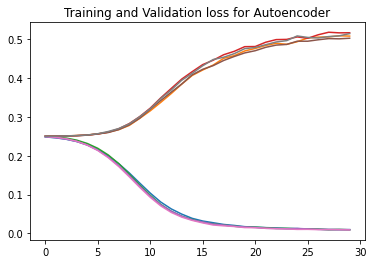

In [17]:
for i in range(NFOLD-1):
    loss = cnn1D_encoder_result[i]['loss']
    val_loss = cnn1D_encoder_result[i]['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Training and Validation loss for Autoencoder')

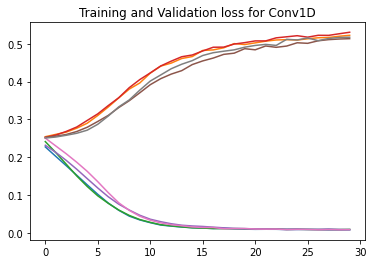

In [18]:
for i in range(NFOLD-1):
    loss = cnnv1D_result[i]['loss']
    val_loss = cnnv1D_result[i]['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Training and Validation loss for Conv1D')

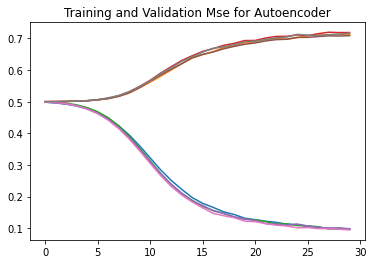

In [19]:
for i in range(NFOLD-1):
    mse = cnn1D_encoder_result[i]['root_mean_squared_error']
    val_mse = cnn1D_encoder_result[i]['val_root_mean_squared_error']
    plt.plot(mse)
    plt.plot(val_mse)
    plt.title('Training and Validation Mse for Autoencoder')

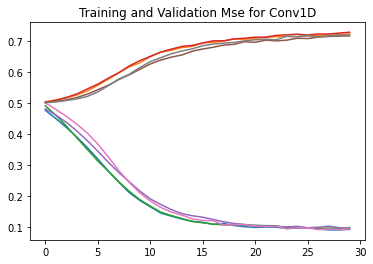

In [20]:
for i in range(NFOLD-1):
    mse = cnnv1D_result[i]['root_mean_squared_error']
    val_mse = cnnv1D_result[i]['val_root_mean_squared_error']
    plt.plot(mse)
    plt.plot(val_mse)
    plt.title('Training and Validation Mse for Conv1D')

26/26 [==============================] - 1s 3ms/step


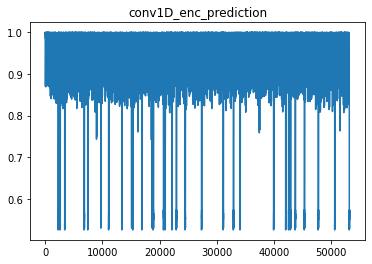

In [21]:
cnn1D_enc_predict = autoencoder.predict(test_dataset, verbose = True)
cnn1D_enc_predict = cnn1D_enc_predict.reshape(-1)
plt.title("conv1D_enc_prediction")
plt.plot(cnn1D_enc_predict)

53248


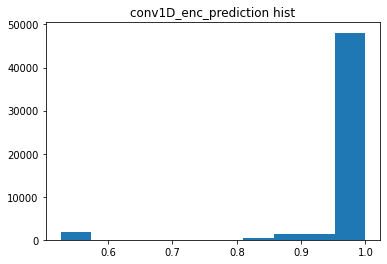

In [22]:
plt.title("conv1D_enc_prediction hist")
plt.hist(cnn1D_enc_predict)
print(cnn1D_enc_predict.size)

26/26 [==============================] - 0s 2ms/step


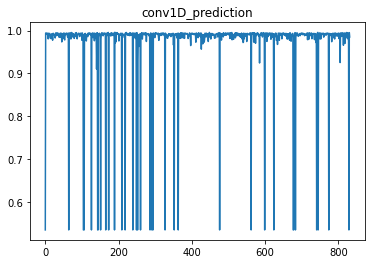

In [23]:
conv1D_predict = conv1D.predict(test_dataset, verbose = True)
plt.title("conv1D_prediction")
plt.plot(conv1D_predict)

832


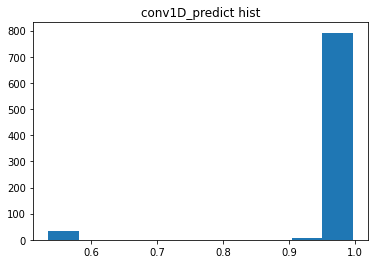

In [24]:
plt.title("conv1D_predict hist")
plt.hist(conv1D_predict)
print(conv1D_predict.size)